In [1]:
import sys
import os
import subprocess

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import re
# import collections
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
# from tqdm import tqdm
import traceback
import hashlib

import event_processing_v3
import postgresql_v3_event_storage
import dataset_query_functions_v3

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt

#import ROOT

# import tool.npy_frames_visualization as npy_vis
import tool.acqconv
from data_analysis_utils import *
# from event_recognition_efficiency_v3 import *
# import supervised_classification as supc

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Welcome to JupyROOT 6.13/02


In [3]:
# simu_signal_event_table='spb_processing_v3_simu_signal.event_uniq_3_1_10001'
simu_signal_event_table='spb_processing_v3_simu_signal.event'
sql_where_clauses_str = " AND program_version='3.1'"

In [4]:
data_snippents_dir = 'ver3_simu_signal_data_snippets'
os.makedirs(data_snippents_dir, exist_ok=True)

In [5]:
event_v3_storage_provider = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_simu_signal.ini'), table_names_version='ver3',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_v3.EventProcessingV3
)

query_functions = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider)

In [6]:
event_v3_storage_provider.data_table_name

'spb_processing_v3_simu_signal.event'

In [9]:
columns_for_analysis_dict = query_functions.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=( 
#         ('^$','^gtu_in_packet$'), '.+_seed_coords_[xy].*', 
#         ('.*','^event_id$'),('^$','^program_version$'), ('^$','^timestamp$'), ('^$','^global_gtu$'), ('^$','^packet_id$'),
#         ('^$','^source_data_type_num$'),('^$','^config_info_id$'), ('^$','^source_file_.+$'),
#         '^(trg|alt|orig|bg)\d*_.+$','.*dbscan.*','.*line_coord.*',
#         '.*proc3.*','.*proc2.*',
#         '^trg_box_per_gtu_.+', '^trg_ec_per_gtu_.+', '^n_persist_.+', '^sum_l1_pdm_.+',
        
#         '.+_norm_sum$', '.+_std$', '.+_mean_gz$', '.+_std_gz$', '.+_mean$',
# #         'proc1_((x|gtu)_[xy]|gtu_[xy])_(width|height|mean|area)$',
#         'proc1_gtu_y'
        
#         '(x_y|gtu_(x|y))_clusters_.+clu_.+$',
        
#         'line_coord_\d+_[xy]'
        '^.+$',
    ),
    
    default_excluded_columns_re_list=[],
#     for debugging selection
    included_columns_re_list=[('^$','^source_file_acquisition_full$'), 
                              ('^$','gtu_in_packet'), ('^$','event_id'), ('^$','num_gtu'),
                             
                              '.*proc1_x_y_max',
                              '.*proc1_(x|gtu)_(x|y)_clusters_count',
                              '.*proc1_(x|gtu)_(x|y)_clusters_sizes_max$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr1_max_clu_major_line_phi$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr1_max_clu_major_line_rho$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr1_major_line_phi$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr1_major_line_rho$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr1_line_clusters_max_size_clu_height$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr1_line_clusters_max_size_clu_width$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr1_line_clusters_count',
                              '.*proc1_(x|gtu)_(x|y)_clusters_count'
                             ]
    
)

In [10]:
#import pprint
split_columns_for_analysis_dict = query_functions.split_to_smaller_dicts(columns_for_analysis_dict,50000)
#print(select_clause_str)
for i,g in enumerate(split_columns_for_analysis_dict):
    tot_items = 0
    for k,vl in g.items():
        tot_items += len(vl)
    print(i,tot_items)
    
    for t, vl in g.items():
        sys.stdout.write(t)
        sys.stdout.write('\n\t- ')
#         print('\t'+(', '.join(vl)))
        print('\n\t- '.join(vl))
        print()
    
    print('-'*60)

0 32
spb_processing_v3_simu_signal.event
	- event_id
	- source_file_acquisition_full
	- gtu_in_packet
	- num_gtu

spb_processing_v3_simu_signal.event_proc1_x_y
	- max

spb_processing_v3_simu_signal.event_proc1_x_y_clusters
	- count
	- sizes_max

spb_processing_v3_simu_signal.event_proc1_gtu_x_clusters
	- count
	- sizes_max

spb_processing_v3_simu_signal.event_proc1_gtu_y_clusters
	- count
	- sizes_max

spb_processing_v3_simu_signal.event_proc1_x_y_hough_peak_thr1
	- major_line_phi
	- major_line_rho
	- max_clu_major_line_phi
	- max_clu_major_line_rho
	- line_clusters_count
	- line_clusters_max_size_clu_width
	- line_clusters_max_size_clu_height

spb_processing_v3_simu_signal.event_proc1_gtu_x_hough_peak_thr1
	- major_line_phi
	- major_line_rho
	- max_clu_major_line_phi
	- max_clu_major_line_rho
	- line_clusters_count
	- line_clusters_max_size_clu_width
	- line_clusters_max_size_clu_height

spb_processing_v3_simu_signal.event_proc1_gtu_y_hough_peak_thr1
	- major_line_phi
	- major_line_rh

In [11]:
current_columns_for_analysis_dict = split_columns_for_analysis_dict[0]

select_clause_str, joined_tables_list = \
    query_functions.get_query_clauses__select(current_columns_for_analysis_dict)
join_clauses_str = \
    query_functions.get_query_clauses__join(joined_tables_list)
where_clauses_str = sql_where_clauses_str
    
events_selection_query = query_functions.get_events_selection_query_plain(
    source_data_type_num=10001,
    select_additional=select_clause_str, join_additional=join_clauses_str,
    where_additional=where_clauses_str,
    order_by='{data_table_name}.event_id', limit=200000, offset=0,
    base_select='',
    data_table_name_overwrite=simu_signal_event_table)

In [12]:
print(events_selection_query)


    SELECT 
        
        spb_processing_v3_simu_signal.event.event_id, spb_processing_v3_simu_signal.event.source_file_acquisition_full, spb_processing_v3_simu_signal.event.gtu_in_packet, spb_processing_v3_simu_signal.event.num_gtu, spb_processing_v3_simu_signal.event_proc1_x_y.max AS proc1_x_y_max, spb_processing_v3_simu_signal.event_proc1_x_y_clusters.count AS proc1_x_y_clusters_count, spb_processing_v3_simu_signal.event_proc1_x_y_clusters.sizes_max AS proc1_x_y_clusters_sizes_max, spb_processing_v3_simu_signal.event_proc1_gtu_x_clusters.count AS proc1_gtu_x_clusters_count, spb_processing_v3_simu_signal.event_proc1_gtu_x_clusters.sizes_max AS proc1_gtu_x_clusters_sizes_max, spb_processing_v3_simu_signal.event_proc1_gtu_y_clusters.count AS proc1_gtu_y_clusters_count, spb_processing_v3_simu_signal.event_proc1_gtu_y_clusters.sizes_max AS proc1_gtu_y_clusters_sizes_max, spb_processing_v3_simu_signal.event_proc1_x_y_hough_peak_thr1.major_line_phi AS proc1_x_y_hough_peak_thr1_major_li

In [13]:
data_df = psql.read_sql(events_selection_query, event_v3_storage_provider.connection)

In [14]:
def angle_difference(a1, a2):
    r = np.abs(a1 - a2) % (2*np.pi)
    if r >= np.pi:
        r = 2*np.pi - r
    return r

def normalize_phi(phi):
    norm_phi = np.arctan2(np.sin(phi), np.cos(phi))
    if norm_phi < 0:
        norm_phi = (2*np.pi + norm_phi)
    # norm_phi = (2*np.pi + norm_phi) * (norm_phi < 0) + norm_phi * (norm_phi > 0)
    return norm_phi

def smaller_angle_difference(a1, a2):
    d = angle_difference(a1,a2)
    if d > np.pi/2:
        d = np.pi - d
    return normalize_phi(d)

def add_diff_columns(events_df, do_copy=False):
    if do_copy:
        events_df_w_diff = events_df.copy()
    else:
        events_df_w_diff = events_df
    events_df_w_diff['proc1_gtu_y_gtu_x_hough_peak_thr1_major_line_phi_diff'] = events_df.apply(lambda x: smaller_angle_difference(x['proc1_gtu_x_hough_peak_thr1_major_line_phi'], x['proc1_gtu_y_hough_peak_thr1_major_line_phi']), axis=1)
    events_df_w_diff['proc1_gtu_y_hough_peak_thr1_major_line_phi_diff_0'] = events_df.apply(lambda x: smaller_angle_difference(0, x['proc1_gtu_y_hough_peak_thr1_major_line_phi']), axis=1)
    events_df_w_diff['proc1_gtu_y_hough_peak_thr1_major_line_phi_diff_pi_over_2'] = events_df.apply(lambda x: smaller_angle_difference(np.pi/2, x['proc1_gtu_y_hough_peak_thr1_major_line_phi']), axis=1)
    events_df_w_diff['proc1_gtu_x_hough_peak_thr1_major_line_phi_diff_0'] = events_df.apply(lambda x: smaller_angle_difference(0, x['proc1_gtu_x_hough_peak_thr1_major_line_phi']), axis=1)
    events_df_w_diff['proc1_gtu_x_hough_peak_thr1_major_line_phi_diff_pi_over_2'] = events_df.apply(lambda x: smaller_angle_difference(np.pi/2, x['proc1_gtu_x_hough_peak_thr1_major_line_phi']), axis=1)

add_diff_columns(data_df)

event_id 7337743419.328254


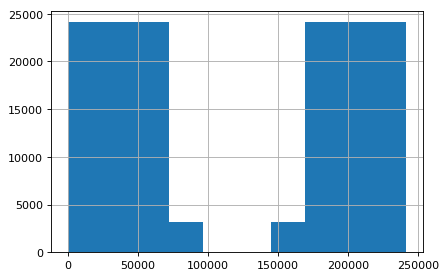

proc1_x_y_max 21.932143522608367


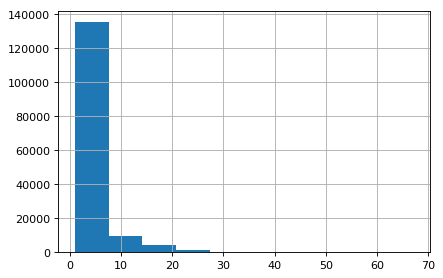

proc1_x_y_clusters_count 3.367752100748247


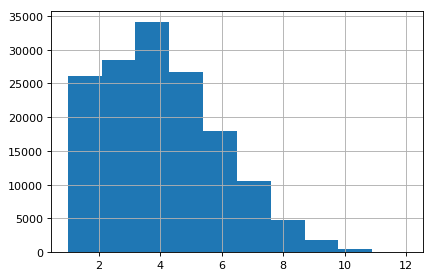

proc1_x_y_clusters_sizes_max 1713.1212061491785


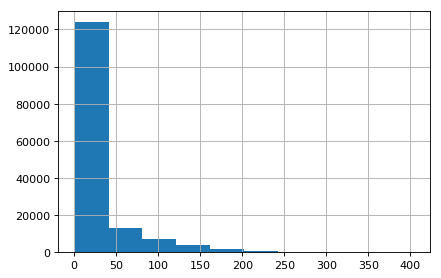

proc1_gtu_x_clusters_count 1.52340415567013


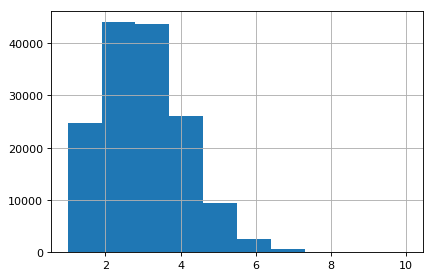

proc1_gtu_x_clusters_sizes_max 714.4002011957111


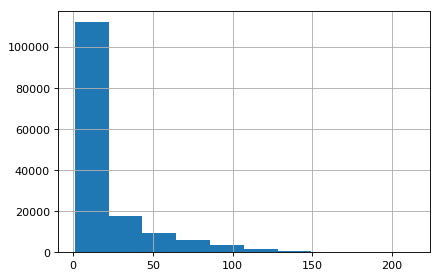

proc1_gtu_y_clusters_count 1.5187026800720433


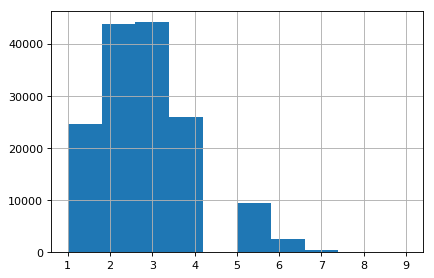

proc1_gtu_y_clusters_sizes_max 706.6576164949975


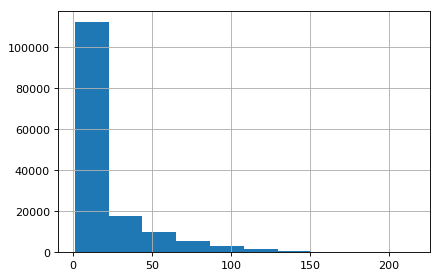

proc1_x_y_hough_peak_thr1_major_line_phi 4.525653442085771


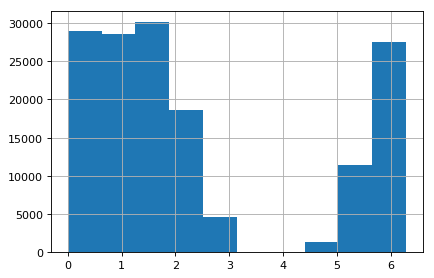

proc1_x_y_hough_peak_thr1_major_line_rho 189.4813422820338


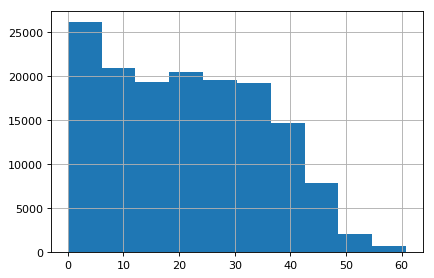

proc1_x_y_hough_peak_thr1_max_clu_major_line_phi 5.24217564966978


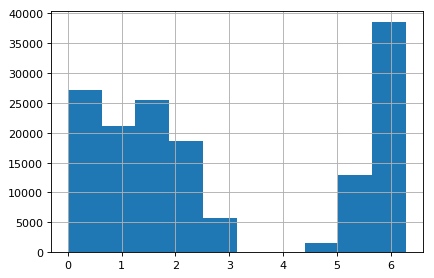

proc1_x_y_hough_peak_thr1_max_clu_major_line_rho 203.6884205697503


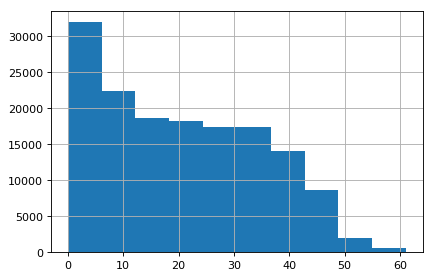

proc1_x_y_hough_peak_thr1_line_clusters_count 2.776690632119263


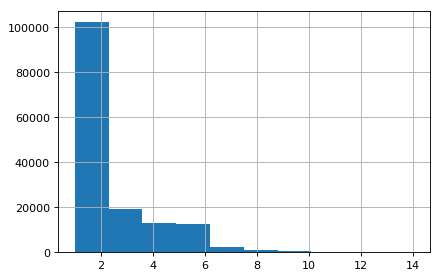

proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width 931.8589885906736


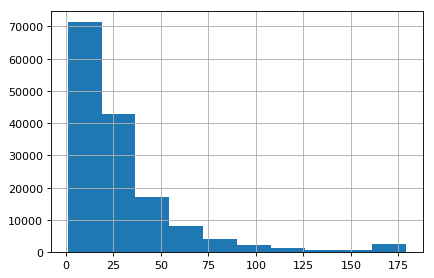

proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_height 553.8716228692506


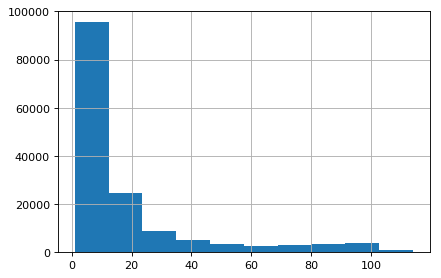

proc1_gtu_x_hough_peak_thr1_major_line_phi 6.943184366166506


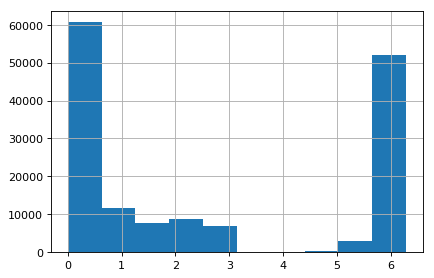

proc1_gtu_x_hough_peak_thr1_major_line_rho 93.8994544716667


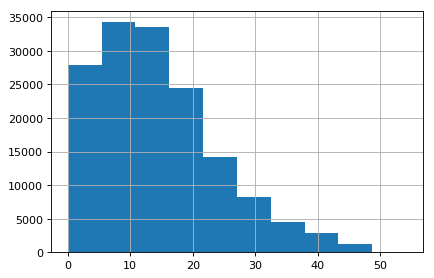

proc1_gtu_x_hough_peak_thr1_max_clu_major_line_phi 7.441381788702912


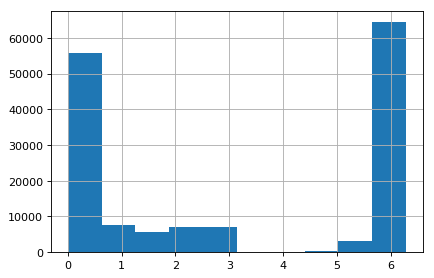

proc1_gtu_x_hough_peak_thr1_max_clu_major_line_rho 88.24207371564698


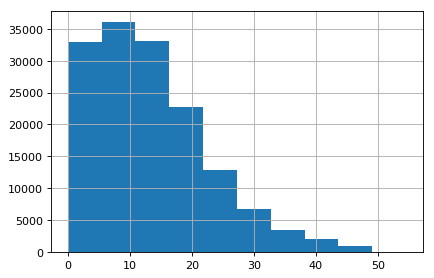

proc1_gtu_x_hough_peak_thr1_line_clusters_count 1.9792036309175365


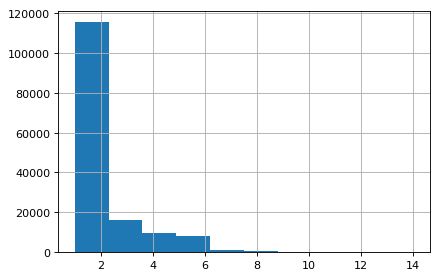

proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_width 682.4196869348707


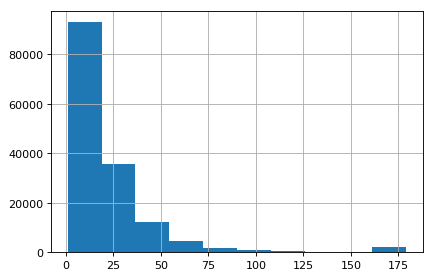

proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_height 217.69323162537998


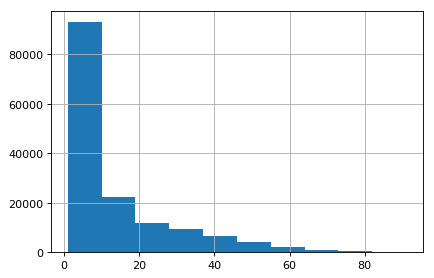

proc1_gtu_y_hough_peak_thr1_major_line_phi 6.87807570507368


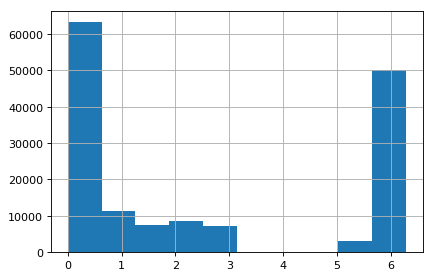

proc1_gtu_y_hough_peak_thr1_major_line_rho 91.16446891492826


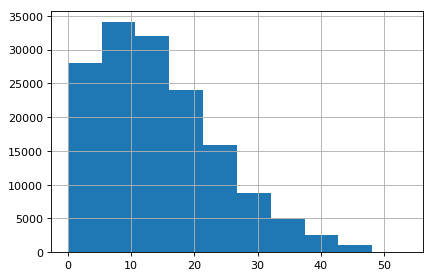

proc1_gtu_y_hough_peak_thr1_max_clu_major_line_phi 7.420771794062396


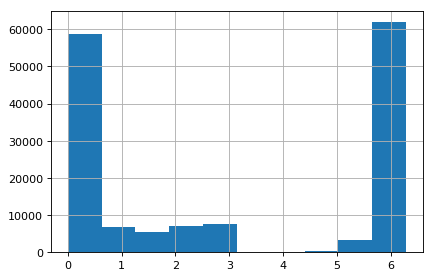

proc1_gtu_y_hough_peak_thr1_max_clu_major_line_rho 86.04179741383945


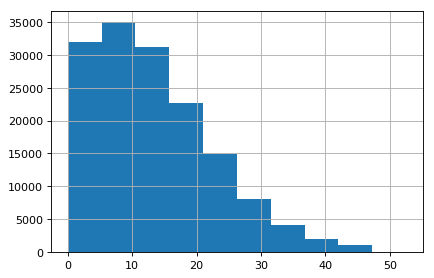

proc1_gtu_y_hough_peak_thr1_line_clusters_count 1.9566138000345474


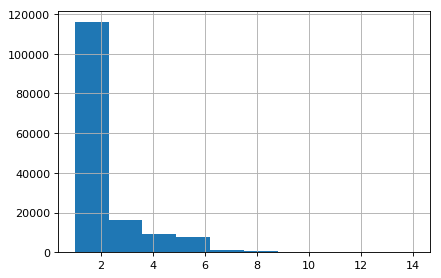

proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width 704.6442886354057


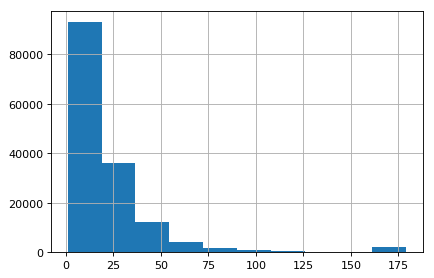

proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_height 225.18933394044052


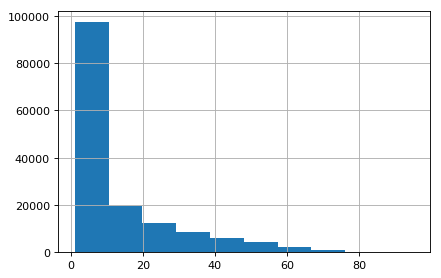

proc1_gtu_y_gtu_x_hough_peak_thr1_major_line_phi_diff 0.18539725455489803


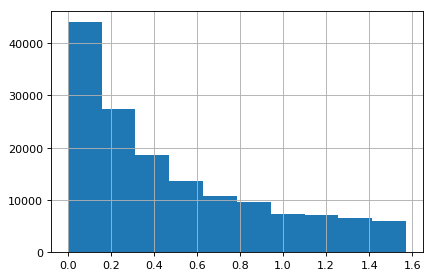

proc1_gtu_y_hough_peak_thr1_major_line_phi_diff_0 0.139034214980369


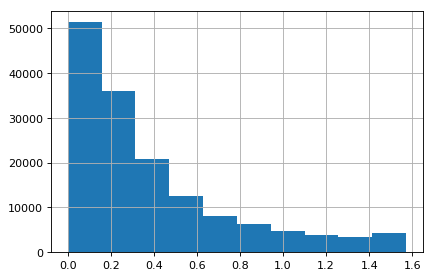

proc1_gtu_y_hough_peak_thr1_major_line_phi_diff_pi_over_2 0.139034214980369


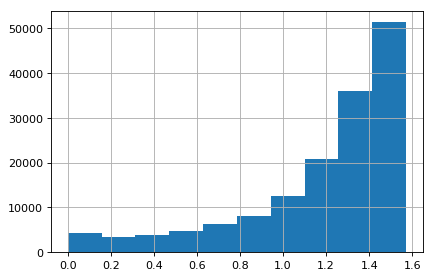

proc1_gtu_x_hough_peak_thr1_major_line_phi_diff_0 0.1450431516899517


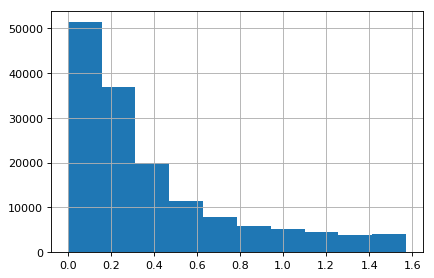

proc1_gtu_x_hough_peak_thr1_major_line_phi_diff_pi_over_2 0.1450431516899517


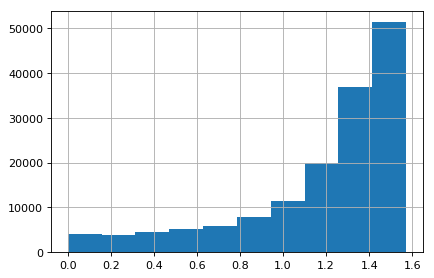

In [15]:
plt.close('all')
for col,col_type in zip(data_df.columns,data_df.dtypes):
    if col_type == object or  data_df[col].var() == 0:
        continue
    print(col, data_df[col].var() )
    data_df[col].hist()
    
    plt.show()

In [59]:
_prev_max_columns = pd.get_option('display.max_columns')
_prev_max_col_width = pd.get_option('display.max_colwidth')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)
data_df

,event_id,source_file_acquisition_full,gtu_in_packet,num_gtu,proc1_x_y_max,proc1_x_y_clusters_count,proc1_x_y_clusters_sizes_mean,proc1_gtu_x_clusters_count,proc1_gtu_x_clusters_sizes_mean,proc1_gtu_y_clusters_count,proc1_gtu_y_clusters_sizes_mean,proc1_x_y_hough_peak_thr1_max_clu_major_line_phi,proc1_x_y_hough_peak_thr1_max_clu_major_line_rho,proc1_x_y_hough_peak_thr1_line_clusters_count,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_gtu_x_hough_peak_thr1_max_clu_major_line_phi,proc1_gtu_x_hough_peak_thr1_max_clu_major_line_rho,proc1_gtu_x_hough_peak_thr1_line_clusters_count,proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_gtu_y_hough_peak_thr1_max_clu_major_line_phi,proc1_gtu_y_hough_peak_thr1_max_clu_major_line_rho,proc1_gtu_y_hough_peak_thr1_line_clusters_count,proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_height
0,101,/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.00e+12/thousnd18_lE_E9.2017-08-02-21h39m46s/simu2npy/ev_13_mc_1__signals.npy,30,38,9,3,26.00000,3,10.66670,2,28.50000,6.247130,4.382010,1.0,14.0,15.0,1.766690,2.726630,1.0,38.0,10.0,6.101490,7.487160,1.0,6.0,4.0
1,103,/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.00e+12/thousnd18_lE_E9.2017-08-02-21h39m46s/simu2npy/ev_23_mc_1__signals.npy,30,38,1,5,2.60000,1,13.00000,2,6.50000,0.142985,31.369100,3.0,11.0,8.0,6.183570,3.419370,4.0,26.0,18.0,6.254440,6.655880,4.0,10.0,18.0
2,104,/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.00e+12/thousnd18_lE_E9.2017-08-02-21h39m46s/simu2npy/ev_29_mc_1__signals.npy,30,38,1,4,1.00000,2,2.00000,4,1.00000,0.008776,40.800200,1.0,13.0,85.0,6.210040,1.980700,3.0,66.0,12.0,5.947260,1.867200,1.0,10.0,7.0
3,105,/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.00e+12/thousnd18_lE_E9.2017-08-02-21h39m46s/simu2npy/ev_38_mc_1__signals.npy,30,38,1,7,1.85714,5,2.40000,6,2.16667,5.784680,13.077600,4.0,20.0,12.0,2.256530,15.852400,2.0,6.0,4.0,1.326460,6.154750,2.0,28.0,6.0
4,106,/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.00e+12/thousnd18_lE_E9.2017-08-02-21h39m46s/simu2npy/ev_59_mc_1__signals.npy,30,38,1,7,1.28571,5,1.80000,4,2.25000,1.779650,6.618350,1.0,8.0,4.0,6.195430,4.221060,2.0,6.0,2.0,5.899990,5.721470,3.0,5.0,3.0
5,107,/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.00e+12/thousnd18_lE_E9.2017-08-02-21h39m46s/simu2npy/ev_64_mc_1__signals.npy,30,38,1,4,1.25000,2,2.50000,3,1.66667,1.476570,17.639600,1.0,36.0,14.0,0.429995,20.279100,2.0,8.0,3.0,1.403130,17.544500,1.0,17.0,3.0
6,108,/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.00e+12/thousnd18_lE_E9.2017-08-02-21h39m46s/simu2npy/ev_65_mc_1__signals.npy,30,38,5,3,18.33330,3,16.00000,2,18.50000,0.983415,34.686100,1.0,13.0,4.0,0.204938,12.642000,1.0,6.0,2.0,5.994330,0.253812,1.0,10.0,6.0
7,109,/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.00e+12/thousnd18_lE_E9.2017-08-02-21h39m46s/simu2npy/ev_86_mc_1__signals.npy,30,38,5,3,15.66670,2,17.00000,3,12.66670,0.476493,39.692200,1.0,11.0,5.0,0.258957,15.109200,1.0,9.0,5.0,6.139710,3.491760,1.0,6.0,4.0
8,110,/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.00e+12/thousnd18_lE_E9.2017-08-02-21h39m46s/simu2npy/ev_8_mc_1__signals.npy,30,38,1,8,1.37500,3,3.66667,4,2.75000,0.413979,21.001500,4.0,35.0,8.0,0.036435,11.176300,1.0,19.0,27.0,0.047633,12.184200,1.0,24.0,30.0
9,111,/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.00e+12/thousnd18_lE_E9.2017-08-02-21h39m46s/simu2npy/ev_99_mc_1__signals.npy,30,38,1,5,2.80000,4,3.50000,5,2.80000,0.206529,14.399000,3.0,17.0,6.0,5.857670,2.488890,2.0,22.0,4.0,0.151287,11.310700,1.0,16.0,9.0


In [60]:
for k, v in data_df.var().iteritems():
    print("{:60s}\t{}".format(k,v))

event_id                                                    	2834608004.6907954
gtu_in_packet                                               	0.0
num_gtu                                                     	0.0
proc1_x_y_max                                               	21.932288659018774
proc1_x_y_clusters_count                                    	3.3677743869169725
proc1_x_y_clusters_sizes_mean                               	779.6422377580025
proc1_gtu_x_clusters_count                                  	1.5234142368284322
proc1_gtu_x_clusters_sizes_mean                             	440.96330429401115
proc1_gtu_y_clusters_count                                  	1.5187127301182344
proc1_gtu_y_clusters_sizes_mean                             	442.5720723152994
proc1_x_y_hough_peak_thr1_max_clu_major_line_phi            	5.242210348600448
proc1_x_y_hough_peak_thr1_max_clu_major_line_rho            	203.68976882109774
proc1_x_y_hough_peak_thr1_line_clusters_count               	2.7767090115

In [61]:
data_w_null_df = data_df[ data_df.isnull().any(axis=1) ]
data_w_null_df

,event_id,source_file_acquisition_full,gtu_in_packet,num_gtu,proc1_x_y_max,proc1_x_y_clusters_count,proc1_x_y_clusters_sizes_mean,proc1_gtu_x_clusters_count,proc1_gtu_x_clusters_sizes_mean,proc1_gtu_y_clusters_count,proc1_gtu_y_clusters_sizes_mean,proc1_x_y_hough_peak_thr1_max_clu_major_line_phi,proc1_x_y_hough_peak_thr1_max_clu_major_line_rho,proc1_x_y_hough_peak_thr1_line_clusters_count,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_gtu_x_hough_peak_thr1_max_clu_major_line_phi,proc1_gtu_x_hough_peak_thr1_max_clu_major_line_rho,proc1_gtu_x_hough_peak_thr1_line_clusters_count,proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_gtu_y_hough_peak_thr1_max_clu_major_line_phi,proc1_gtu_y_hough_peak_thr1_max_clu_major_line_rho,proc1_gtu_y_hough_peak_thr1_line_clusters_count,proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_height
7283,8836,/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.78e+12/thousnd33E5.2017-07-25-17h20m09s/simu2npy/ev_28_mc_1__signals.npy,30,38,1,1,1.0,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13922,16799,/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_2.82e+12/thousnd33E9/simu2npy/ev_6_mc_1__signals.npy,30,38,1,1,1.0,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14322,17280,/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_3.16e+12/thousnd33E10.2017-07-25-23h14m55s/simu2npy/ev_62_mc_1__signals.npy,30,38,1,1,1.0,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14772,17821,/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_3.16e+12/thousnd33E10.2017-07-25-23h39m47s/simu2npy/ev_22_mc_1__signals.npy,30,38,1,1,1.0,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19884,23938,/home/spbproc/SPBDATA_processed/spb_simu/posz_27000000.00/energy_3.98e+12/thousnd27E12.2017-07-25-04h34m12s/simu2npy/ev_19_mc_1__signals.npy,30,38,1,1,1.0,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28072,33722,/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_6.31e+12/thousnd33E16.2017-07-26-08h14m35s/simu2npy/ev_70_mc_1__signals.npy,30,38,1,1,1.0,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31202,37411,/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_7.08e+12/thousnd33E17.2017-07-26-10h12m15s/simu2npy/ev_22_mc_1__signals.npy,30,38,1,1,1.0,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32233,38639,/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_7.08e+12/thousnd33E17.2017-07-26-10h51m51s/simu2npy/ev_11_mc_1__signals.npy,30,38,1,1,1.0,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33592,40257,/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_7.94e+12/thousnd33E18.2017-07-26-11h34m03s/simu2npy/ev_52_mc_1__signals.npy,30,38,1,1,1.0,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37052,44346,/home/spbproc/SPBDATA_processed/spb_simu/posz_27000000.00/energy_8.91e+12/thousnd27E19.2017-07-25-16h22m04s/simu2npy/ev_5_mc_1__signals.npy,30,38,1,1,1.0,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
def show_simu_events(data_to_vis_df, nrows=7, ncols=9, vis_xy=True, vis_gtux=True, vis_gtuy=True):
    plt.close('all')

    fig, axs = plt.subplots(nrows, ncols)
    fig.set_size_inches(ncols*5,nrows*5)
    axs_flattened = axs.flatten()
    ai = 0

    for i,(rid,r) in enumerate(data_to_vis_df.iterrows()):
        simu_gtu_start = r['gtu_in_packet']-4-30
        simu_gtu_end = simu_gtu_start+r['num_gtu']

        if ai+2 >= len(axs_flattened):
            break

        print( r['source_file_acquisition_full'], r['source_file_acquisition_full'], "#{} i{}".format(i, r['event_id']), (simu_gtu_start,simu_gtu_end) )
        visualize_simu_event_projections(r['source_file_acquisition_full'], title="#{} i{}".format(i, r['event_id']), axs_flattened=axs_flattened, 
                                        vis_xy=vis_xy, vis_gtux=vis_gtux, vis_gtuy=vis_gtuy, 
                                        ai=ai,
                                        gtu_range=(simu_gtu_start, simu_gtu_end), get_simunpy_func=lambda acq: acq)
        ai += 3

        if ai >= len(axs_flattened):
            break
    plt.show()

/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.78e+12/thousnd33E5.2017-07-25-17h20m09s/simu2npy/ev_28_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.78e+12/thousnd33E5.2017-07-25-17h20m09s/simu2npy/ev_28_mc_1__signals.npy #0 i8836 (-4, 34)
len(event_frames)=41 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=34 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_2.82e+12/thousnd33E9/simu2npy/ev_6_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_2.82e+12/thousnd33E9/simu2npy/ev_6_mc_1__signals.npy #1 i16799 (-4, 34)
len(event_frames)=42 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=34 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_3.16e+12/thousnd33E10.2017-07-25-23h14m55s/simu2npy/ev_62_mc_1__signals.npy /home/sp

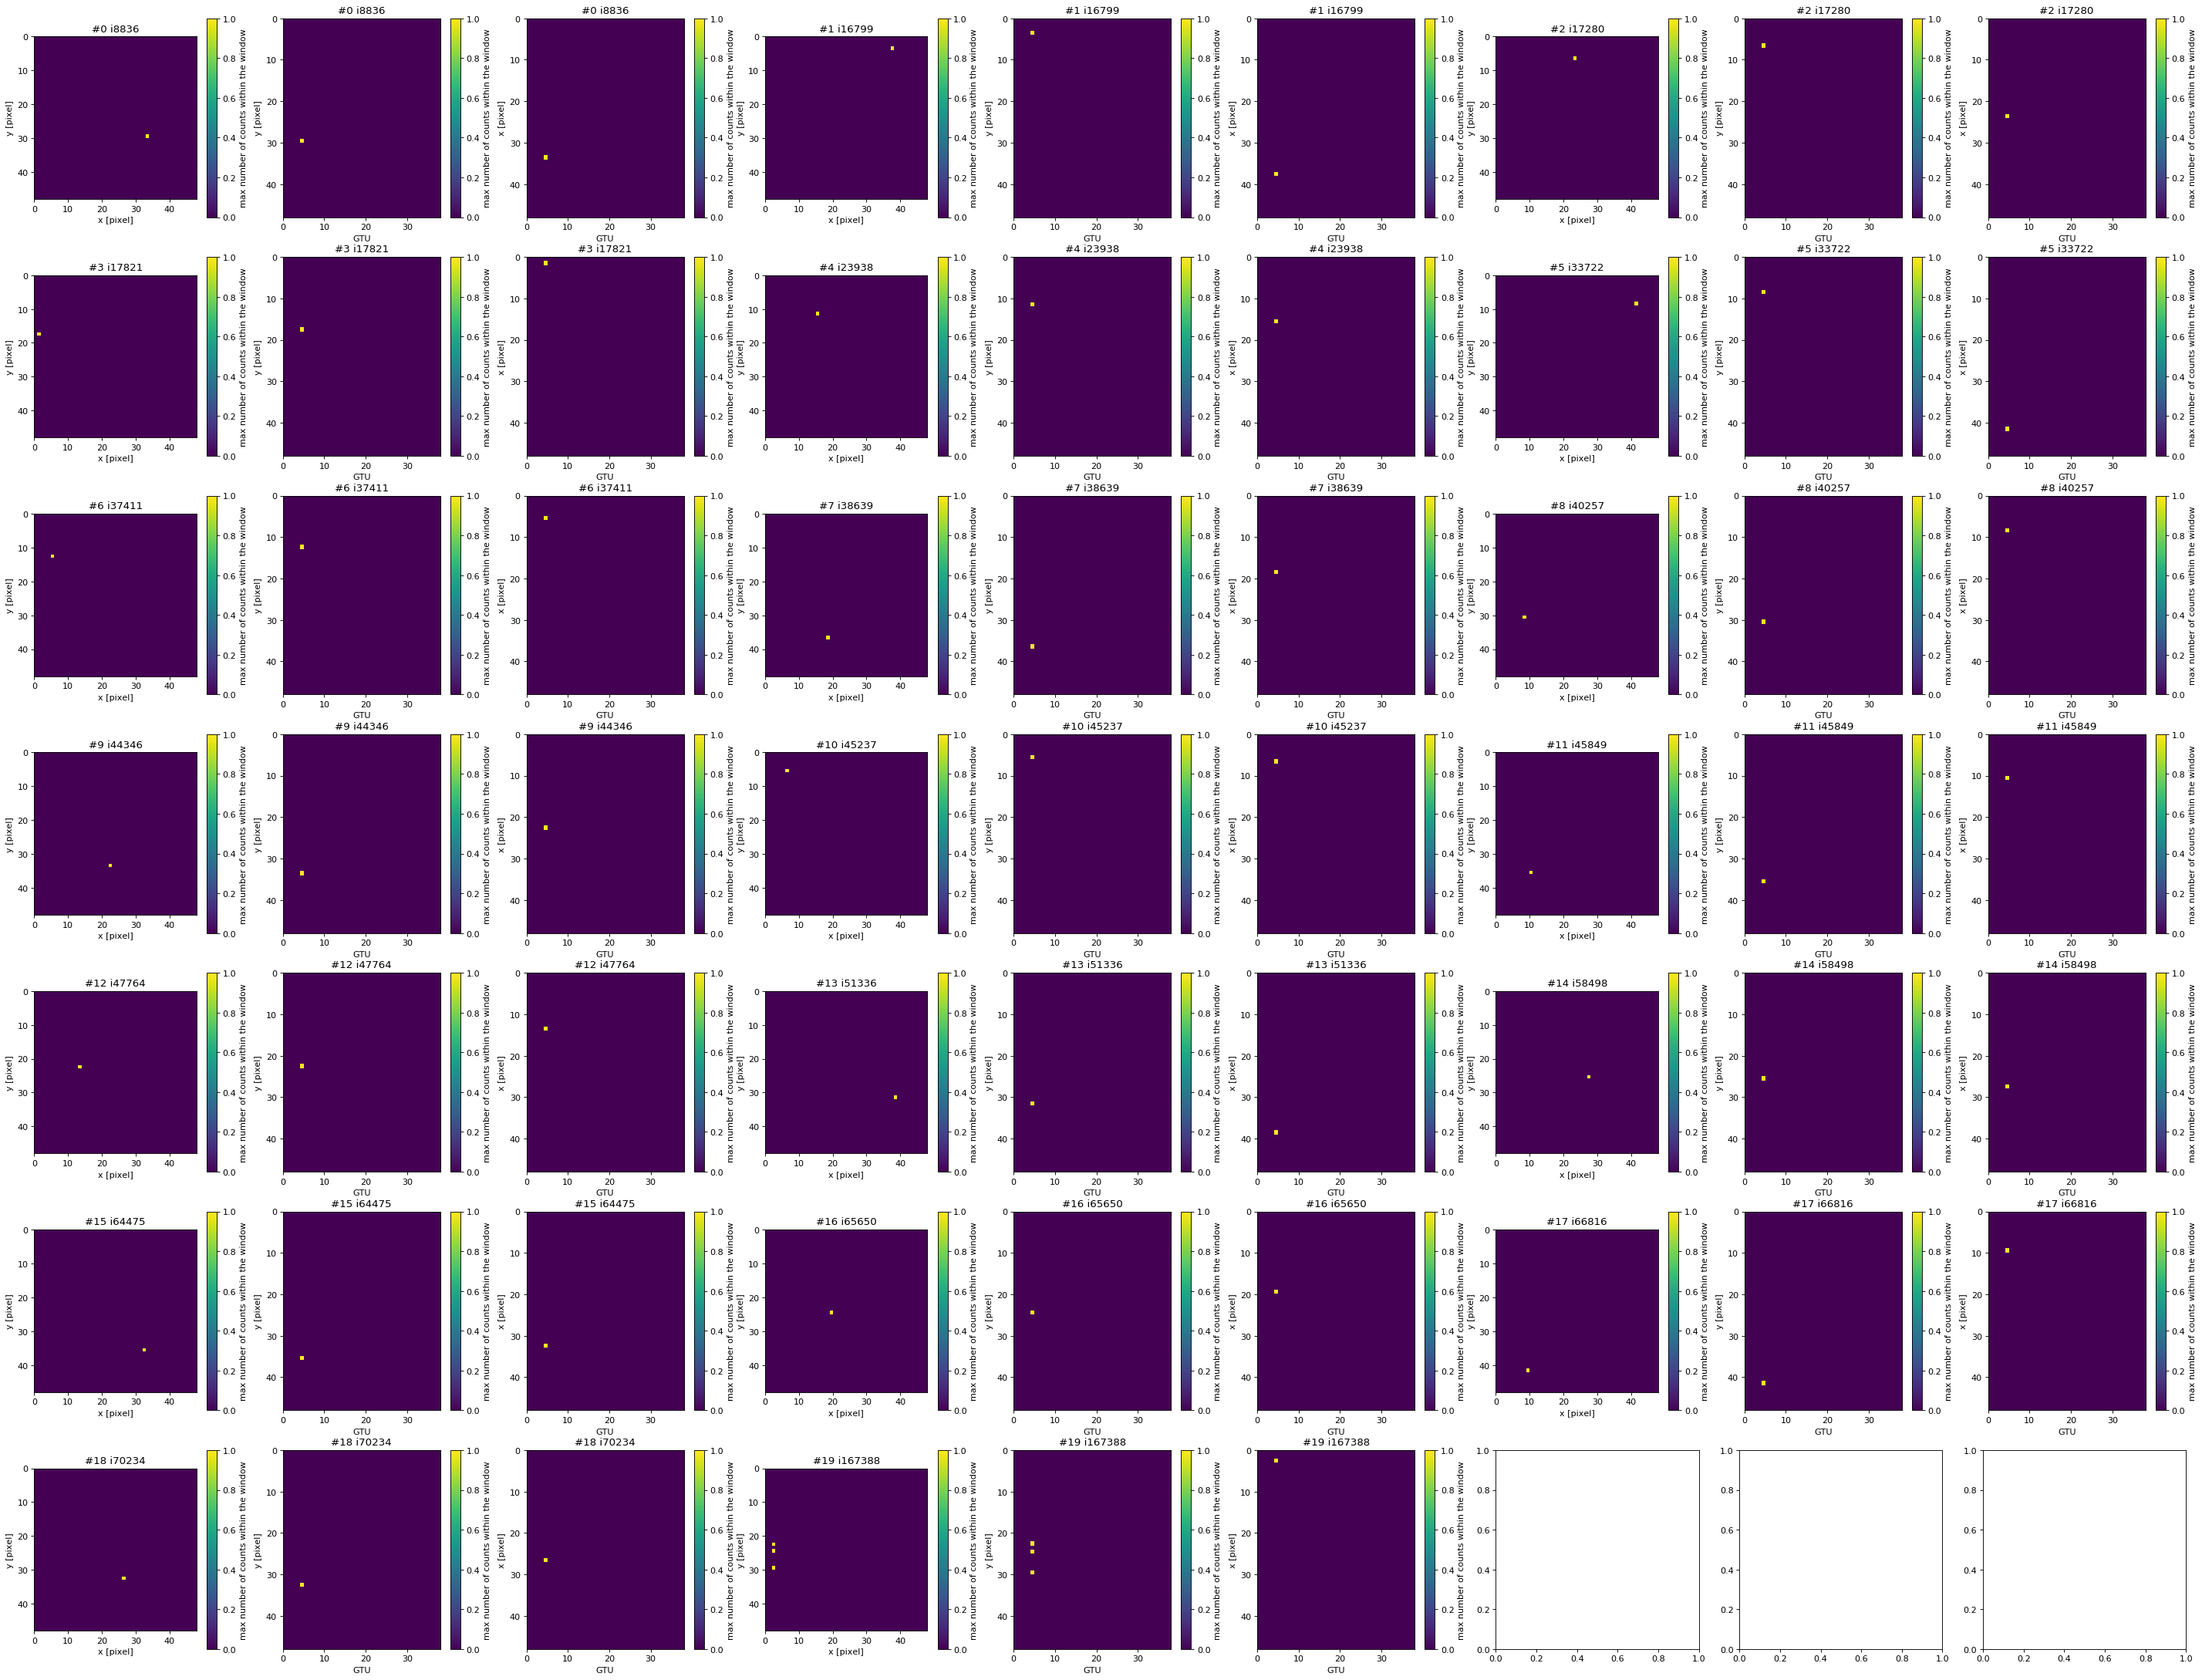

In [63]:
show_simu_events(data_w_null_df)

In [64]:
data_df.describe()

,event_id,gtu_in_packet,num_gtu,proc1_x_y_max,proc1_x_y_clusters_count,proc1_x_y_clusters_sizes_mean,proc1_gtu_x_clusters_count,proc1_gtu_x_clusters_sizes_mean,proc1_gtu_y_clusters_count,proc1_gtu_y_clusters_sizes_mean,proc1_x_y_hough_peak_thr1_max_clu_major_line_phi,proc1_x_y_hough_peak_thr1_max_clu_major_line_rho,proc1_x_y_hough_peak_thr1_line_clusters_count,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_gtu_x_hough_peak_thr1_max_clu_major_line_phi,proc1_gtu_x_hough_peak_thr1_max_clu_major_line_rho,proc1_gtu_x_hough_peak_thr1_line_clusters_count,proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_gtu_y_hough_peak_thr1_max_clu_major_line_phi,proc1_gtu_y_hough_peak_thr1_max_clu_major_line_rho,proc1_gtu_y_hough_peak_thr1_line_clusters_count,proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_height
count,75558.000000,75558.0,75558.0,75558.000000,75558.000000,75558.000000,75558.000000,75558.000000,75558.000000,75558.000000,7.553900e+04,75539.000000,75539.000000,75539.000000,75539.000000,75538.000000,75538.000000,75538.000000,75538.000000,75538.000000,75539.000000,75539.000000,75539.000000,75539.000000,75539.000000
mean,59636.570833,30.0,38.0,2.842889,4.247571,12.136840,2.746817,12.799480,2.746367,12.765092,2.858704e+00,20.558672,2.252916,29.931373,18.434795,3.132562,13.513508,1.912005,22.022518,12.826246,3.039447,13.478907,1.902620,22.087769,12.895273
std,53241.036848,0.0,0.0,4.683192,1.835150,27.922074,1.234267,20.999126,1.232361,21.037397,2.289587e+00,14.271992,1.666346,30.158004,23.534555,2.727899,9.393756,1.406846,26.789471,14.754480,2.724118,9.275902,1.398795,26.949775,15.006359
min,101.000000,30.0,38.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.072920e-09,0.000359,1.000000,1.000000,1.000000,0.000000,0.000642,1.000000,1.000000,1.000000,0.000000,0.001535,1.000000,1.000000,1.000000
25%,22739.250000,30.0,38.0,1.000000,3.000000,1.400000,2.000000,2.000000,2.000000,2.000000,9.413160e-01,7.544490,1.000000,13.000000,5.000000,0.238017,6.213252,1.000000,7.000000,3.000000,0.223917,6.153030,1.000000,7.000000,3.000000
50%,45222.500000,30.0,38.0,1.000000,4.000000,2.333330,3.000000,4.000000,3.000000,4.000000,1.938310e+00,19.194800,2.000000,20.000000,9.000000,2.485570,11.888400,1.000000,14.000000,6.000000,2.350300,11.841900,1.000000,14.000000,6.000000
75%,67833.750000,30.0,38.0,2.000000,5.000000,8.000000,4.000000,13.000000,4.000000,13.000000,5.668910e+00,32.218550,3.000000,36.000000,19.000000,6.089720,18.767975,2.000000,26.000000,17.000000,6.076775,19.036300,2.000000,26.000000,17.000000
max,178014.000000,30.0,38.0,67.000000,12.000000,403.000000,10.000000,213.000000,9.000000,215.000000,6.283190e+00,61.087500,14.000000,179.000000,114.000000,6.283190,54.553900,14.000000,179.000000,91.000000,6.283190,52.519200,14.000000,179.000000,95.000000


In [65]:
pd.set_option('display.max_columns', _prev_max_columns)
pd.set_option('display.max_colwidth', _prev_max_col_width)

In [66]:
dropped_data_columns = ['event_id','gtu_in_packet','source_file_acquisition_full']
data_variances = data_df.var()
for k,v in data_variances.iteritems():
    if v == 0:
        dropped_data_columns.append(k)
print(dropped_data_columns)

['event_id', 'gtu_in_packet', 'source_file_acquisition_full', 'gtu_in_packet', 'num_gtu']


In [67]:
data_for_clustering_df = data_df.drop(dropped_data_columns,axis=1).dropna()

In [68]:
import sklearn
import sklearn.preprocessing

In [69]:
def scale_data(X, scaler_picke_pathname, pickle_overwrite=False, scaler_class=sklearn.preprocessing.StandardScaler):
    scaler = None

    if scaler_picke_pathname:
        if isinstance(scaler_picke_pathname, str) and os.path.isdir(scaler_picke_pathname):
            print('Calculating hash of data ...')
            data_md5 = hashlib.md5(pickle.dumps(X, protocol=0))
            scaler_picke_pathname = os.path.join(scaler_picke_pathname, 'scaler_for_{}.joblib.pkl'.format(data_md5.hexdigest()))

        if os.path.exists(scaler_picke_pathname) and not pickle_overwrite:
            print("Loading existing scaler...")
            scaler = sklearn.externals.joblib.load(scaler_picke_pathname)

    if not scaler:
        print('StandardScaler - fitting and transforming data ...')
        scaler = scaler_class()

        if scaler_picke_pathname:
            print("Saving scaled data into file {}".format(scaler_picke_pathname))
            sklearn.externals.joblib.dump(scaler, scaler_picke_pathname)

        X = scaler_class().fit_transform(X)
    else:
        print('Scaler - transforming data ...')
        X = scaler.transform(X)

    return X

In [70]:
scaled_data = scale_data(data_for_clustering_df.values, None)

StandardScaler - fitting and transforming data ...


In [71]:
scaled_data

array([[ 1.31448273, -0.68048515,  0.49633784, ..., -0.6452943 ,
        -0.59695147, -0.59276591],
       [-0.39357404,  0.40965922, -0.34162076, ...,  1.49941512,
        -0.44852719,  0.34017192],
       [-0.39357404, -0.13541297, -0.39891708, ..., -0.6452943 ,
        -0.44852719, -0.39285066],
       ...,
       [-0.39357404,  0.40965922, -0.37743096, ..., -0.6452943 ,
        -0.59695147, -0.59276591],
       [-0.39357404, -0.13541297, -0.38996453, ...,  0.78451198,
        -0.41142112, -0.25957383],
       [ 0.03344016, -0.13541297,  0.16509352, ..., -0.6452943 ,
        -0.52273933, -0.59276591]])

In [72]:
import sklearn.cluster
import sklearn.decomposition

In [73]:
# decomp_pca = sklearn.decomposition.PCA(n_components=100,svd_solver='randomized')
decomp_pca = sklearn.decomposition.PCA(n_components=None,svd_solver='full')
scaled_data_pca = decomp_pca.fit_transform(scaled_data)

In [74]:
scaled_data_pca

array([[ 1.32667197, -1.38814708, -1.09017084, ...,  0.80466039,
         0.09781071, -0.31455611],
       [-0.89088699, -0.4351485 , -2.05814392, ...,  0.31218711,
         0.30090615, -0.00366113],
       [-0.9358139 ,  0.46728371, -1.04024982, ...,  1.10947588,
        -0.06437281, -0.20795378],
       ...,
       [-0.56309249, -0.07496822, -1.12279614, ...,  0.48386536,
         0.22642772,  0.0275854 ],
       [-0.786295  , -1.56999935, -1.41805949, ...,  0.35373313,
         0.14114278, -0.14343206],
       [ 0.8649468 ,  3.24345294,  1.31679487, ...,  1.17694734,
        -0.22994456, -0.0568731 ]])

In [75]:
cluster_dbscan_scaled_pca = sklearn.cluster.DBSCAN(eps=0.1, min_samples=10).fit(scaled_data)
print( np.max(cluster_dbscan_scaled_pca.labels_) )

-1


In [76]:
# cluster_minibatch_scaled = sklearn.cluster.MiniBatchKMeans(n_clusters=2).fit(scaled_data)
# print(np.max(cluster_minibatch_scaled.labels_))
# print('ones:\t',np.count_nonzero(cluster_minibatch_scaled.labels_))
# print('zeros:\t',len(scaled_data)-np.count_nonzero(cluster_minibatch_scaled.labels_))

In [77]:
cluster_kmeans_scaled = sklearn.cluster.KMeans(n_clusters=2).fit(scaled_data)
print(np.max(cluster_kmeans_scaled.labels_))
print('zeros:\t',len(scaled_data)-np.count_nonzero(cluster_kmeans_scaled.labels_))
print('ones:\t',np.count_nonzero(cluster_kmeans_scaled.labels_))

1
zeros:	 11474
ones:	 64064


In [78]:
cluster_kmeans_scaled_pca = sklearn.cluster.KMeans(n_clusters=2).fit(scaled_data_pca)
print(np.max(cluster_kmeans_scaled_pca.labels_))
print('zeros:\t',len(scaled_data)-np.count_nonzero(cluster_kmeans_scaled_pca.labels_))
print('ones:\t',np.count_nonzero(cluster_kmeans_scaled_pca.labels_))

1
zeros:	 11476
ones:	 64062


In [79]:
# cluster_agglomerative_scaled = sklearn.cluster.AgglomerativeClustering(n_clusters=2,linkage='ward').fit(scaled_data)
# print(np.max(cluster_agglomerative_scaled.labels_))
# print('ones:\t',np.count_nonzero(cluster_agglomerative_scaled.labels_))
# print('zeros:\t',len(scaled_data)-np.count_nonzero(cluster_agglomerative_scaled.labels_))

In [80]:
# TAKES TOO LONG
# cluster_spectral_scaled = sklearn.cluster.SpectralClustering(n_clusters=2,eigen_solver='arpack',affinity="nearest_neighbors").fit(scaled_data)
# print(np.max(cluster_kmeans_scaled.labels_))
# print('ones:\t',np.count_nonzero(cluster_spectral_scaled.labels_))
# print('zeros:\t',len(scaled_data)-np.count_nonzero(cluster_spectral_scaled.labels_))

In [89]:
clustered_to_vis = cluster_kmeans_scaled

In [90]:
data_df['cluster_kmeans_label'] = -1
data_df.loc[ ~data_df.isnull().any(axis=1), 'cluster_kmeans_label' ] = clustered_to_vis.labels_


In [91]:
data_df_kmeans_clu_0 = data_df[ data_df['cluster_kmeans_label'] == 0 ].sort_values(
    by=['proc1_x_y_max','proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width'],
    ascending=[False, True])
data_df_kmeans_clu_1 = data_df[ data_df['cluster_kmeans_label'] == 1 ].sort_values(
    by=['proc1_x_y_max','proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width'],
    ascending=[False, True])

/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_3.35e+12/simu.2017-07-17-05h07m34s/simu2npy/ev_18_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_3.35e+12/simu.2017-07-17-05h07m34s/simu2npy/ev_18_mc_1__signals.npy #0 i171740 (-4, 34)
len(event_frames)=24 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=24 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_21000000.00/energy_8.91e+12/thousnd21E19.2017-07-28-16h10m59s/simu2npy/ev_70_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_21000000.00/energy_8.91e+12/thousnd21E19.2017-07-28-16h10m59s/simu2npy/ev_70_mc_1__signals.npy #1 i48740 (-4, 34)
len(event_frames)=30 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=30 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_6.85e+12/simu.2017-07-22-20h27m06s/simu2npy/ev_93_

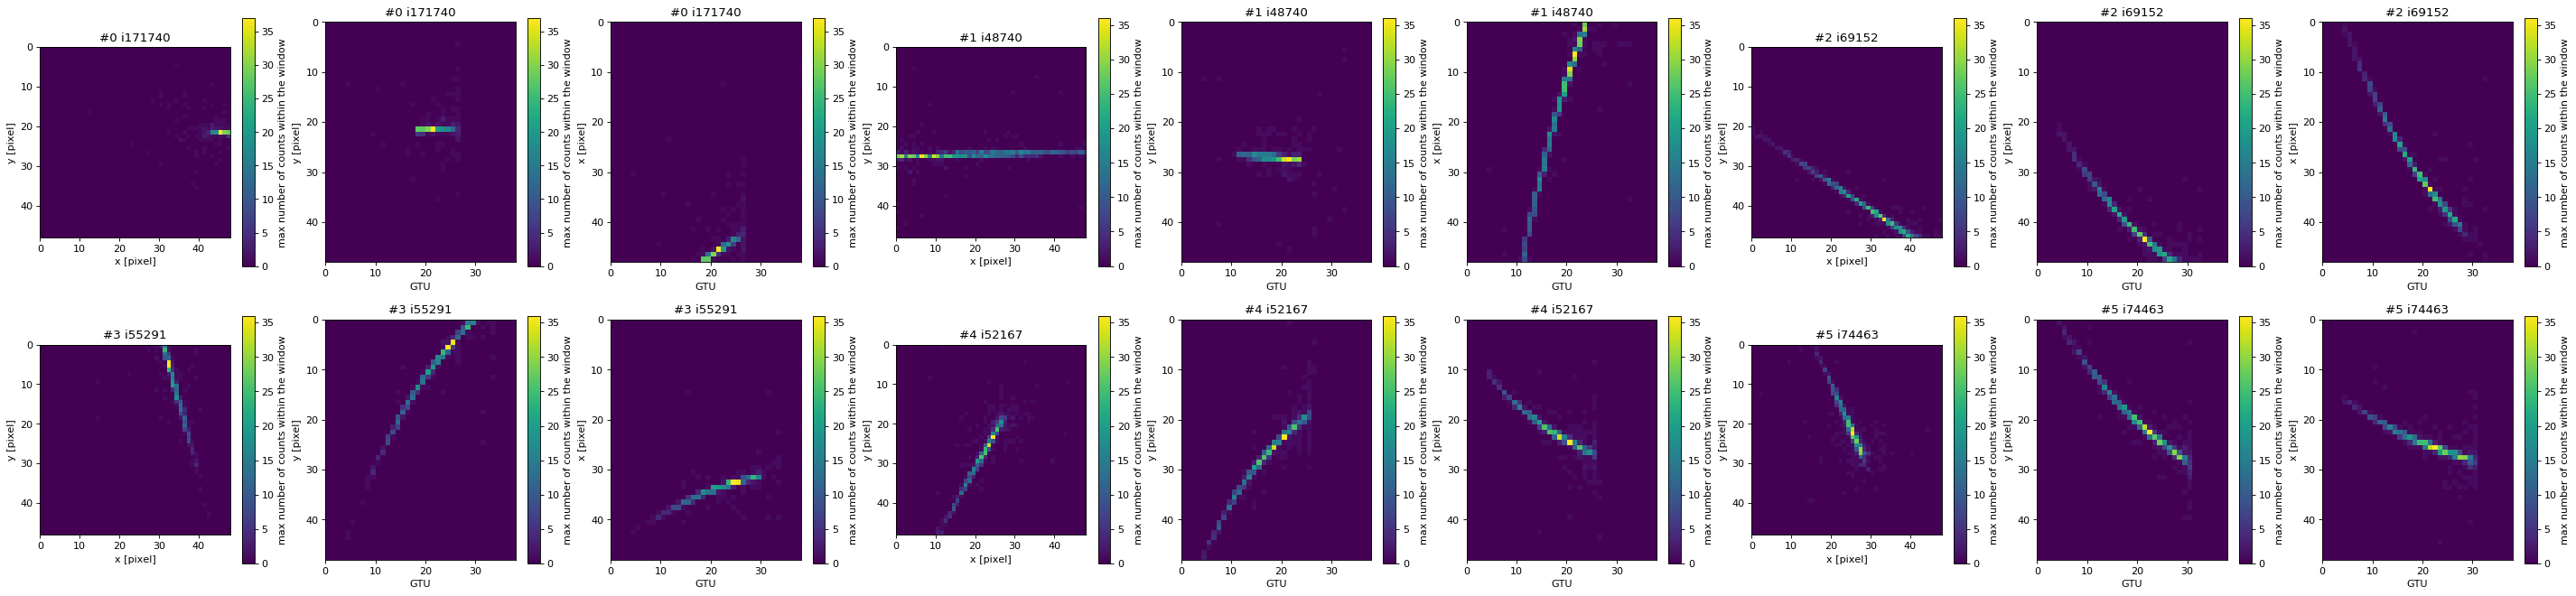

In [92]:
show_simu_events( data_df_kmeans_clu_0.iloc[100:] , 2 )

/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_6.20e+12/simu.2017-07-22-03h49m26s/simu2npy/ev_8_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_6.20e+12/simu.2017-07-22-03h49m26s/simu2npy/ev_8_mc_1__signals.npy #0 i58771 (-4, 34)
len(event_frames)=26 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=26 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_7.75e+12/simu.2017-07-24-04h18m24s/simu2npy/ev_20_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_7.75e+12/simu.2017-07-24-04h18m24s/simu2npy/ev_20_mc_1__signals.npy #1 i72893 (-4, 34)
len(event_frames)=32 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=32 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_7.75e+12/simu.2017-07-24-02h51m07s/simu2npy/ev_82_mc_1__signals.npy /

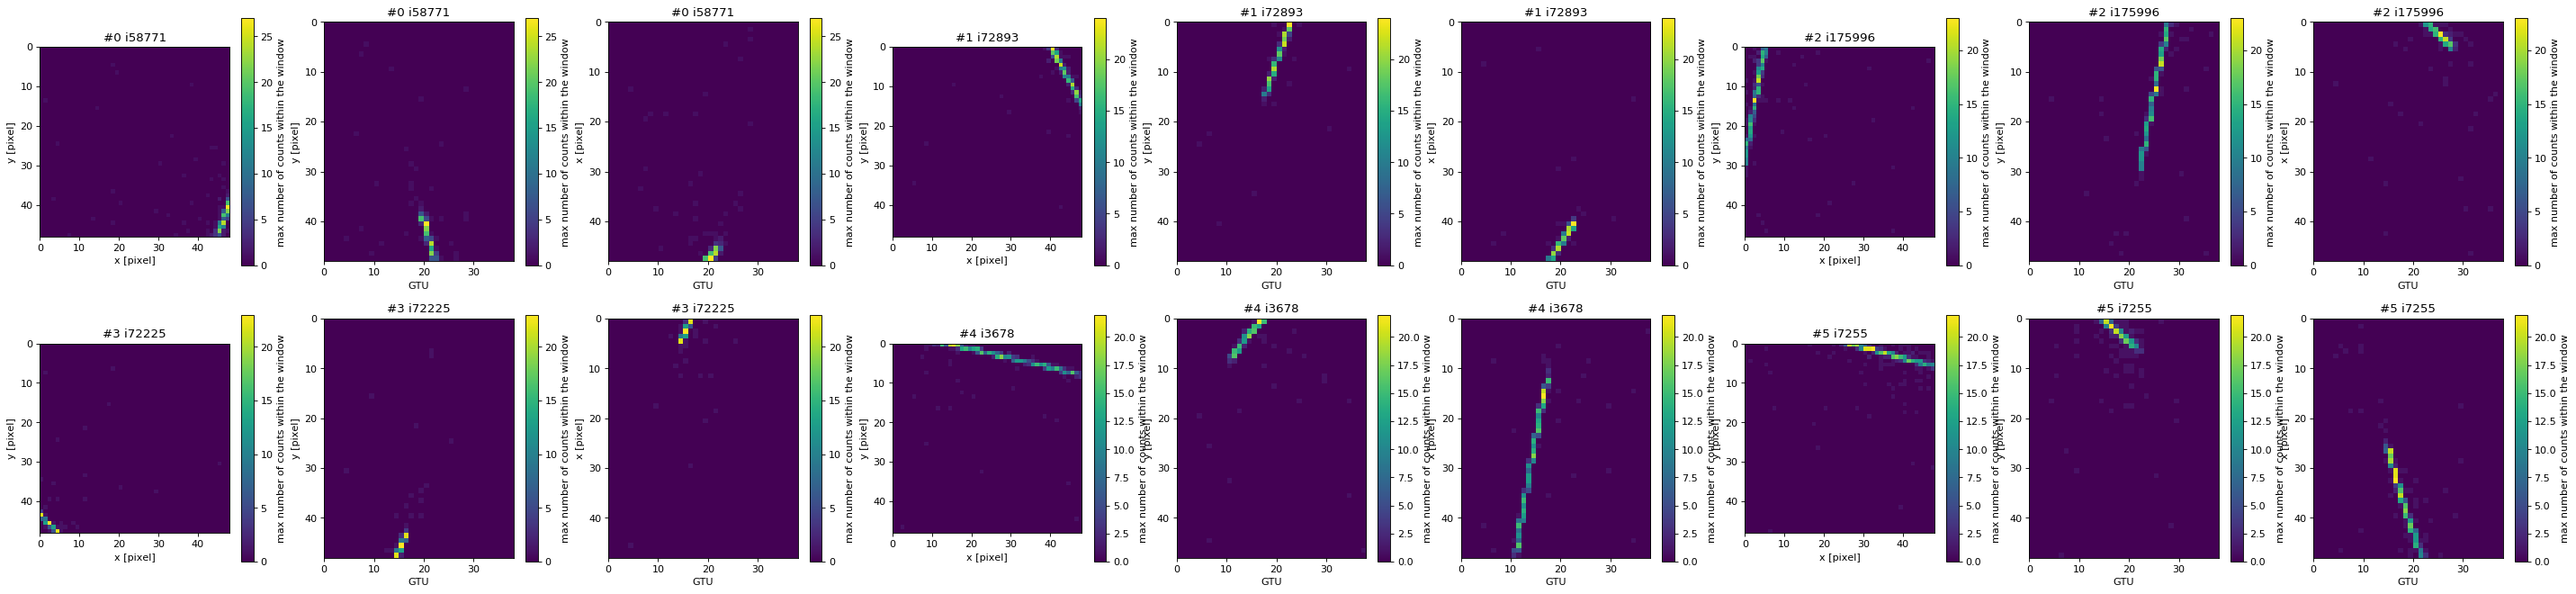

In [93]:
show_simu_events( data_df_kmeans_clu_1.iloc[0:] , 2 )